```
[VISKOM_Final-Assignment]Road Sign Detection using YOLOv5

*   Reza Donsika Putra - 1301201403
*   Ketut Tangkas Anggrawisesa - 1301204388
```

# Extract dataset

In [1]:
import os
import zipfile

# extract dataset ke folder data
current_directory = os.getcwd()
zip_filename = "road_sign_detection_dataset.zip"
local_zip = os.path.join(current_directory, zip_filename)
zip_ref = zipfile.ZipFile(local_zip, 'r')
extract_directory = os.path.join(current_directory, 'road-sign-detection')
zip_ref.extractall(extract_directory)
zip_ref.close()

# ubah folder annotations menjadi labels
annotations_folder = "annotations"
annotations_folder_path = os.path.join(extract_directory, annotations_folder)
labels_folder = "labels"
labels_folder_path = os.path.join(extract_directory, labels_folder)
os.rename(annotations_folder_path, labels_folder_path)

# YOLOv5

In [2]:
!pip install --upgrade imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6


In [3]:
%%bash
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


Cloning into 'yolov5'...


# Preprocessing

In [4]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

In [12]:
input_path = 'road-sign-detection'
output_path = 'yolov5'

In [13]:
labels_path = os.path.join(input_path, 'labels')
labels = os.listdir(labels_path)

In [14]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(labels))):

    tree = ET.parse(os.path.join(labels_path, labels[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

100%|██████████| 877/877 [00:00<00:00, 2095.14it/s]


In [15]:
labels_df = pd.DataFrame({
                        'img_name': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label
0,road593.png,300,400,74,66,151,142,speedlimit
1,road697.png,300,400,103,166,134,198,speedlimit
2,road697.png,300,400,102,216,132,247,speedlimit
3,road643.png,300,400,80,182,112,214,speedlimit
4,road319.png,300,400,127,189,171,234,speedlimit


# Labelling

In [16]:
!pip install pybboxes

In [17]:
import numpy as np
import pandas as pd
import os
import pybboxes as pbx
from collections import defaultdict
from tqdm import tqdm
import shutil

In [18]:
classes = labels_df['label'].unique().tolist()
classes

['speedlimit', 'trafficlight', 'crosswalk', 'stop']

In [19]:
## Add class number associated to classes
labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,class
0,road593.png,300,400,74,66,151,142,speedlimit,0
1,road697.png,300,400,103,166,134,198,speedlimit,0
2,road697.png,300,400,102,216,132,247,speedlimit,0
3,road643.png,300,400,80,182,112,214,speedlimit,0
4,road319.png,300,400,127,189,171,234,speedlimit,0


In [ ]:
classes_values = labels_df['class'].unique().tolist()
classes_values

In [20]:
## Generate dictionary where key is image_name and value is list of all bboxes inforamtion
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))

    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)

100%|██████████| 1244/1244 [00:00<00:00, 5761.83it/s]


In [21]:
# make labels dir in data folder of yolov5
labels_dir = f'{output_path}/data/yolo_labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [22]:
## Generate .txt file for each image
for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

# Split Data

In [23]:
import os
import shutil
from random import shuffle

In [24]:
images_path = input_path + '/images'
labels_path = labels_dir   ## directory having labels in .txt format

In [25]:
# create train , val folders in data directory of yolov5
train_dir = output_path + '/data/train'
val_dir = output_path + '/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(train_dir)
os.mkdir(val_dir)

# train, val each containing images and labels folders
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')

In [26]:
# Shuffle image file names before splitting into train and val data
files = os.listdir(images_path)
shuffle(files)

In [27]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]

def copy_files(images_path, labels_path, destination_path, files):

    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [28]:
images_path, labels_path, train_dir

('road-sign-detection/images', 'yolov5/data/yolo_labels', 'yolov5/data/train')

In [29]:
# Split and copy files in train and val folder
train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

root = 'data/traffic_sign_data'

copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [30]:
assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

In [31]:
with open(f'{output_path}/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

# Train Model

In [34]:
epochs = 20
!python /content/yolov5/train.py --img 640 --batch 16 --epochs {epochs} --data sign_data.yaml --weights yolov5s.pt

2023-12-29 19:38:26.105065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 19:38:26.105219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 19:38:26.305125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=sign_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, p

In [74]:
exp = sorted(os.listdir(output_path + '/runs/train'))[-1]
exp_path = output_path + '/runs/train/' + exp

In [75]:
os.listdir(exp_path)

['PR_curve.png',
 'opt.yaml',
 'val_batch2_labels.jpg',
 'F1_curve.png',
 'val_batch0_labels.jpg',
 'val_batch1_pred.jpg',
 'results.png',
 'labels_correlogram.jpg',
 'weights',
 'val_batch1_labels.jpg',
 'train_batch2.jpg',
 'val_batch0_pred.jpg',
 'confusion_matrix.png',
 'train_batch1.jpg',
 'hyp.yaml',
 'events.out.tfevents.1703878711.c8cab1b3e5c1.11962.0',
 'labels.jpg',
 'train_batch0.jpg',
 'results.csv',
 'P_curve.png',
 'R_curve.png',
 'val_batch2_pred.jpg']

# Validation

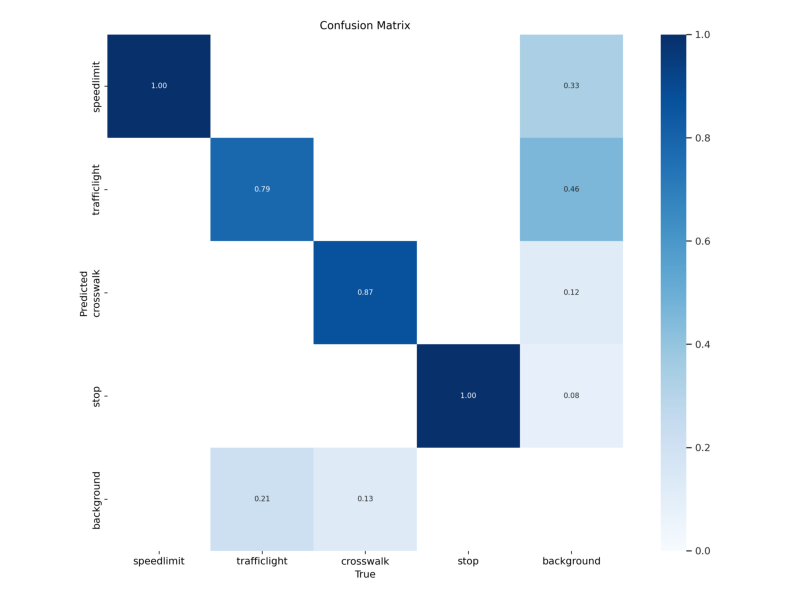

In [76]:
import cv2
import matplotlib.pyplot as plt

#Plot confusion matrix
confusion_matrix_img_path = "/content/yolov5/runs/train/exp/confusion_matrix.png"
confusion_matrix_img = cv2.imread(confusion_matrix_img_path)
confusion_matrix_img_rgb = cv2.cvtColor(confusion_matrix_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix_img_rgb)
plt.axis('off')
plt.show()

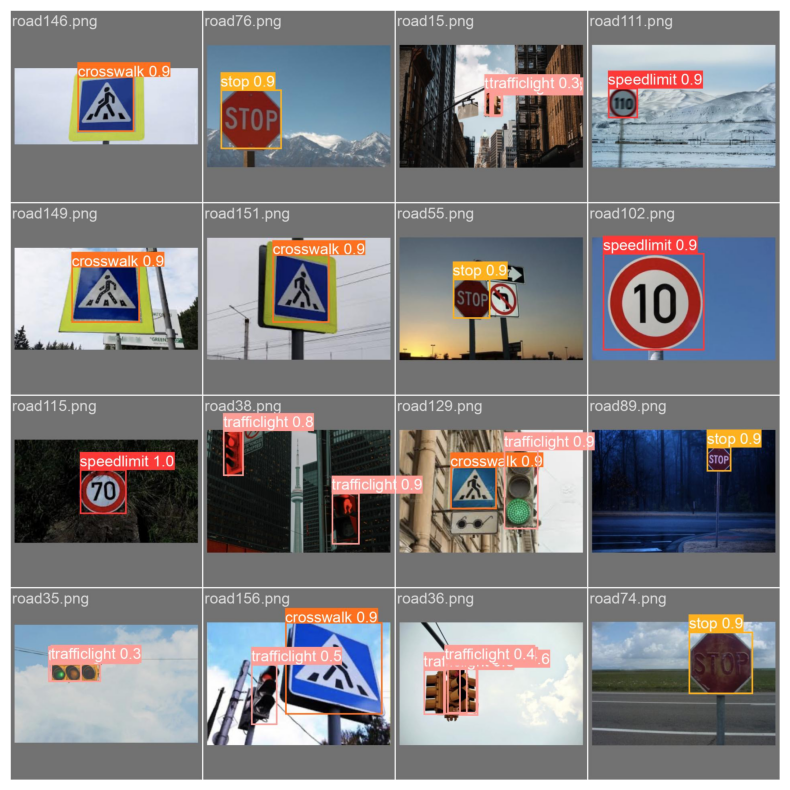

In [77]:
#Plot val pred0
pred0_img_path = "/content/yolov5/runs/train/exp/val_batch0_pred.jpg"
pred0_img = cv2.imread(pred0_img_path)
pred0_img_rgb = cv2.cvtColor(pred0_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(pred0_img_rgb)
plt.axis('off')
plt.show()

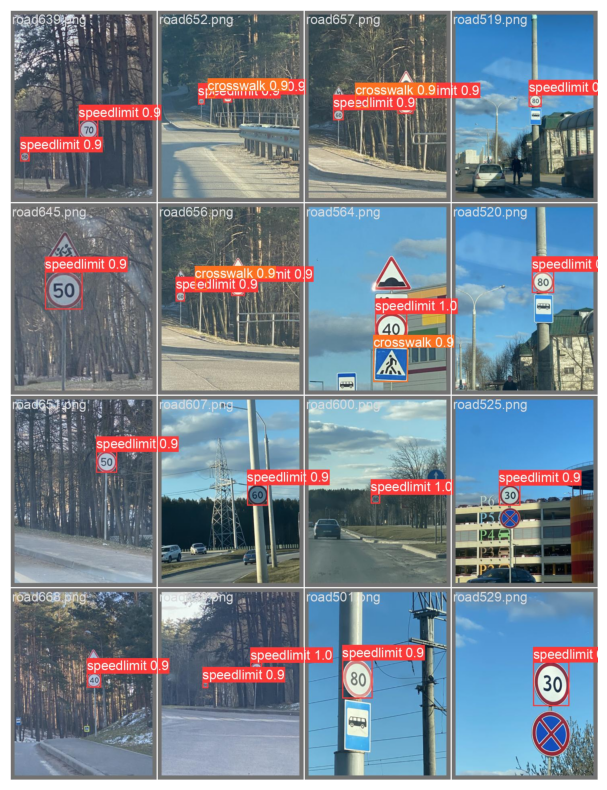

In [78]:
#Plot val pred1
pred1_img_path = "/content/yolov5/runs/train/exp/val_batch1_pred.jpg"
pred1_img = cv2.imread(pred1_img_path)
pred1_img_rgb = cv2.cvtColor(pred1_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(pred1_img_rgb)
plt.axis('off')
plt.show()

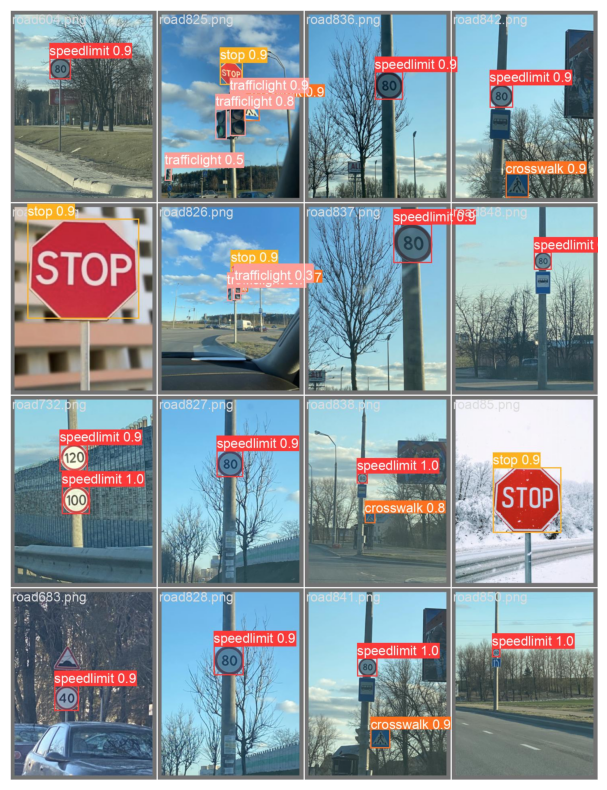

In [79]:
#Plot val pred2
pred2_img_path = "/content/yolov5/runs/train/exp/val_batch2_pred.jpg"
pred2_img = cv2.imread(pred2_img_path)
pred2_img_rgb = cv2.cvtColor(pred2_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(pred2_img_rgb)
plt.axis('off')
plt.show()